In [1]:
import logging
import os
import sys
from pathlib import Path
from typing import Dict

import h5py
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import xarray as xr

notebook_path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
project_dir = notebook_path.parent.parent
sys.path.append(str(project_dir))
import src.utils.custom_log as custom_log
from src.utils.CfCFilter import CfCFilter
from src.utils.Csv import Csv
from src.utils.iso18571 import ISO18571
from src.utils.ReadBinout import ReadBinout
from src.utils.set_rcparams import set_rcparams
from src.utils.UnifySignal import UnifySignal

# logging
custom_log.set_level(custom_log.LEVELS.INFO)
LOG: logging.Logger = custom_log.init_logger(__name__)
LOG.info("Log initialized")

# working dir
os.chdir(project_dir)
LOG.info("Working directory: %s", os.getcwd())

# set plot style
set_rcparams()

2024-06-20 11:17:39,307 MainProcess - MainThread INFO Setting rcparams for matplotlib || set_rcparams.py
2024-06-20 11:17:39,324 MainProcess - MainThread INFO Using style src/visualization/dissertation.mplstyle || set_rcparams.py


# Parameter & Init

In [2]:
# data
READ_NEW: bool = True
B_PATH: Path = Path("/mnt") / "q" / "AWARE2ALL"
LOG.info("Base path: %s, Exist: %s, Read New: %s", B_PATH, B_PATH.is_dir(), READ_NEW)

# Paths
DYNA_SIM_DIR: Path = B_PATH / "original_model_dyna" / "Assemblies" / "50th_Base"
VPS_SIM_DIR: Path = B_PATH / "from_esi" / "2024-06-13_ESI_result_files_v4"

# container
DATA: Dict[str, pd.DataFrame] = {}
ISO_SCORES: pd.DataFrame = pd.DataFrame()
UNIFIER: UnifySignal = UnifySignal(target_tend_ms=130, target_tstart_ms=0, target_sampling_rate_ms=0.1)

# Get Data

In [3]:
def read_dyna_sim() -> pd.DataFrame:
    parquet_path = DYNA_SIM_DIR / "extracted.parquet"
    if READ_NEW or not parquet_path.is_file():
        with ReadBinout(sim_dir=DYNA_SIM_DIR) as binout:
            # read belt data
            LOG.info("Read belt data")
            db_belt = binout.binout.as_df("secforc", "total_force")
            db_belt.rename(columns={v: f"belt_B{int(v[-1])+2}" for v in db_belt.columns}, inplace=True)
            db_belt.index *= 1000
            db_temp = {}
            for channel in ("retractor_pull_out", "retractor_force"):
                db_temp[f"belt_{'B0' if 'force' in channel else channel}"] = binout.binout.as_df("sbtout", channel)
            db_temp = pd.DataFrame(db_temp)
            db_temp.index *= 1000
            db_belt = pd.concat([UNIFIER.unify(db=db_belt), UNIFIER.unify(db=db_temp)], axis=1)
            LOG.info("Belt data: %s", db_belt.shape)

            # read PAB data
            LOG.info("Read PAB data")
            db_pab = {}
            for channel in ("volume", "total_mass", "gas_temp", "pressure", "dm_dt_out", "dm_dt_in"):
                db_pab[f"pab_{channel}"] = binout.binout.as_df("abstat", channel)
            db_pab = pd.DataFrame(db_pab)
            db_pab.index *= 1000
            db_pab = UNIFIER.unify(db=db_pab)

            # mass flow to mass
            for channel in db_pab.columns:
                if "dm_dt" in channel:
                    db_pab[channel] = scipy.integrate.cumulative_trapezoid(
                        y=db_pab[channel],
                        x=db_pab.index / 1000,
                        initial=db_pab[channel].iloc[0],
                    )
            db_pab.rename(columns={v: v.replace("dm_dt", "mass") for v in db_pab.columns}, inplace=True)
            db_pab.rename(columns={"pab_gas_temp": "pab_temperature", "pab_total_mass": "pab_mass"}, inplace=True)

            LOG.info("PAB data: %s", db_pab.shape)

        db_all = pd.concat([db_belt, db_pab], axis=1)
        LOG.info("All data: %s", db_all.shape)

        LOG.info("Save data to %s", parquet_path)
        db_all.to_parquet(parquet_path)
    elif parquet_path.is_file():
        LOG.info("Read data from %s", parquet_path)
        db_all = pd.read_parquet(parquet_path)
        LOG.info("All data: %s", db_all.shape)
    else:
        LOG.critical("No data found: %s", parquet_path)
        db_all = pd.DataFrame()

    return db_all


DATA["Dyna_AM50_HIII"] = read_dyna_sim()
DATA["Dyna_AM50_HIII"]

2024-06-20 11:17:39,384 MainProcess - MainThread INFO Process simulation from /mnt/q/AWARE2ALL/original_model_dyna/Assemblies/50th_Base in /tmp/50th_Base_dwe6kxbr || ReadBinout.py
2024-06-20 11:17:40,873 MainProcess - MainThread INFO Opened ['/tmp/50th_Base_dwe6kxbr/binout0000', '/tmp/50th_Base_dwe6kxbr/binout0004', '/tmp/50th_Base_dwe6kxbr/binout0007', '/tmp/50th_Base_dwe6kxbr/binout0002'] || ReadBinout.py
/tmp/ipykernel_2424814/2330872803.py:30: DeprecationWarning: The option for values for `initial` other than None or 0 is deprecated as of SciPy 1.12.0 and will raise a value error in SciPy 1.15.0.
  db_pab[channel] = scipy.integrate.cumulative_trapezoid(


,belt_B3,belt_B4,belt_B5,belt_B6,belt_B0,belt_retractor_pull_out,pab_mass_in,pab_mass_out,pab_temperature,pab_pressure,pab_mass,pab_volume
0.0,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,2.700460e-19,294.000061,0.101300,0.000026,2.432229e+07
0.1,0.053037,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,5.807589e-11,294.000061,0.101300,0.000026,2.432229e+07
0.2,0.000001,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,1.742333e-10,294.000061,0.101300,0.000026,2.432229e+07
0.3,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,3.143472e-10,294.000061,0.101300,0.000026,2.432229e+07
0.4,0.000000,0.099960,0.000000,0.055122,0.100000,0.000000,0.000000,4.784152e-10,294.000061,0.101300,0.000026,2.432229e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
129.6,229.524881,416.999535,207.999302,142.272446,197.846677,137.400645,0.000057,6.321703e-05,680.938607,0.101242,0.000020,4.317915e+07
129.7,380.797083,489.755294,184.195819,135.400416,228.623850,137.400953,0.000057,6.321861e-05,681.083905,0.101340,0.000020,4.314449e+07
129.8,294.018247,519.891287,134.768035,125.073643,239.559305,137.401062,0.000057,6.322225e-05,681.127739,0.101369,0.000020,4.312620e+07
129.9,378.757597,398.712045,171.805062,98.575988,239.562988,137.401062,0.000057,6.322580e-05,681.078450,0.101336,0.000020,4.312886e+07


In [4]:
def read_vps_sim(model: str) -> pd.DataFrame:
    LOG.info("Read VPS data for %s", model)
    in_path = [x for x in VPS_SIM_DIR.rglob("*") if x.is_file() and model in x.stem]
    parquet_path = DYNA_SIM_DIR / f"extracted_{model}.parquet"
    ts = "/post/multistate/TIMESERIES1/multientityresults/"
    const = "/post/constant/"
    if not in_path:
        LOG.critical("No files found for %s", model)
        return pd.DataFrame()
    else:
        in_path: Path = in_path[0]

    if READ_NEW or not parquet_path.is_file():
        LOG.info("Read data from %s", in_path)
        with h5py.File(in_path) as h5:
            # pab
            db_pab = pd.DataFrame(
                h5.get(ts + "AIRBAG/BAG_VARIABLES/ZONE1_set1/erfblock/res")[:, 0, :],
                columns=[x.decode() for x in h5.get(const + "variablegroup/BAG_VARIABLES/erfblock/varkey")],
                index=h5.get(ts + "AIRBAG/BAG_VARIABLES/ZONE1_set1/erfblock/indexval")[:, 0],
            )
            db_pab.drop(
                columns=[v for v in db_pab.columns if v.split("_")[-1] not in {"Mass", "Pressure", "Volume", "Temperature"}],
                inplace=True,
            )
            db_pab.rename(columns={v: v.lower().replace("airbag", "pab") for v in db_pab.columns}, inplace=True)
            db_pab.rename(columns={"pab_inlet_mass": "pab_mass_in", "pab_outlet_mass": "pab_mass_out"}, inplace=True)
            db_pab.index *= 1000
            db_pab = UNIFIER.unify(db=db_pab)
            LOG.info("PAB data: %s", db_pab.shape)

            # belt
            db_belt_ = None
            for i in range(3):
                db_belt = pd.DataFrame(
                    h5.get(ts + "SECTION/Section_Force/ZONE1_set1/erfblock/res")[:, :, i],
                    columns=[x.decode() for x in h5.get(const + "attributes/SECTION/erfblock/title")],
                    index=h5.get(ts + "SECTION/Section_Force/ZONE1_set1/erfblock/indexval")[:, 0],
                )
                db_belt.drop(columns=[v for v in db_belt.columns if "SEAT_BELT" not in v], inplace=True)
                if db_belt_ is None:
                    db_belt_ = db_belt**2
                else:
                    db_belt_ += db_belt**2
            db_belt = np.sqrt(db_belt_)
            db_belt.rename(columns={v: f"belt_{v.split('_')[-2]}" for v in db_belt.columns}, inplace=True)
            db_belt.index *= 1000
            db_belt = UNIFIER.unify(db=db_belt)
            LOG.info("Belt data: %s", db_belt.shape)

            # retractor
            db_retr = pd.DataFrame(
                    h5.get(ts + "RETRACTOR/Retractor_Variables/ZONE1_set1/erfblock/res")[:, 0, :],
                    columns=[x.decode() for x in h5.get(const + "variablegroup/Retractor_Variables/erfblock/varkey")],
                    index=h5.get(ts + "RETRACTOR/Retractor_Variables/ZONE1_set1/erfblock/indexval")[:, 0],
                )
            db_retr.index *= 1000
            db_retr = UNIFIER.unify(db=db_retr)
            db_belt["belt_B0"] = db_retr["RETRACTOR_Force"]
            db_belt["belt_retractor_pull_out"] = db_retr["RETRACTOR_Reel_InOut_Length"]


        db_all = pd.concat([db_belt, db_pab], axis=1)
        LOG.info("All data: %s", db_all.shape)

        return db_all


for mo in ("AM50_HIII", "VH-50"):
    DATA[f"VPS_{mo}"] = read_vps_sim(model=mo)

In [5]:
cfc = CfCFilter()
for key in DATA.keys():
    DATA[key] = pd.DataFrame(cfc.filter(tsp=1e-4, signal=DATA[key].values, cfc=180), index=DATA[key].index, columns=DATA[key].columns)

In [6]:
def get_iso_score(mode: str) -> Dict[str, float]:
    channels = DATA["Dyna_AM50_HIII"].columns
    t_min, t_max = 20, 120
    scores = {}
    for ch in channels:
        scores[ch] = ISO18571().rating_iso_18571(
            signal_comp=DATA[mode].loc[t_min:t_max, ch].values,
            signal_ref=DATA["Dyna_AM50_HIII"].loc[t_min:t_max, ch].values,
        )['ISO 18571 Rating']

    return scores

ISO_SCORES = {}
for key in DATA.keys():
    if key != "Dyna_AM50_HIII":
        ISO_SCORES[key] = get_iso_score(key)
ISO_SCORES = pd.DataFrame(ISO_SCORES)
ISO_SCORES

,VPS_AM50_HIII,VPS_VH-50
belt_B3,0.774972,0.604314
belt_B4,0.765074,0.675642
belt_B5,0.722634,0.611720
belt_B6,0.765973,0.599960
belt_B0,0.716064,0.619445
belt_retractor_pull_out,0.387112,0.370719
pab_mass_in,0.816578,0.816581
pab_mass_out,0.835049,0.833853
pab_temperature,0.984444,0.972344
pab_pressure,0.329331,0.312094


# Plots

In [7]:
sorted(DATA["Dyna_AM50_HIII"].columns)

['belt_B0',
 'belt_B3',
 'belt_B4',
 'belt_B5',
 'belt_B6',
 'belt_retractor_pull_out',
 'pab_mass',
 'pab_mass_in',
 'pab_mass_out',
 'pab_pressure',
 'pab_temperature',
 'pab_volume']

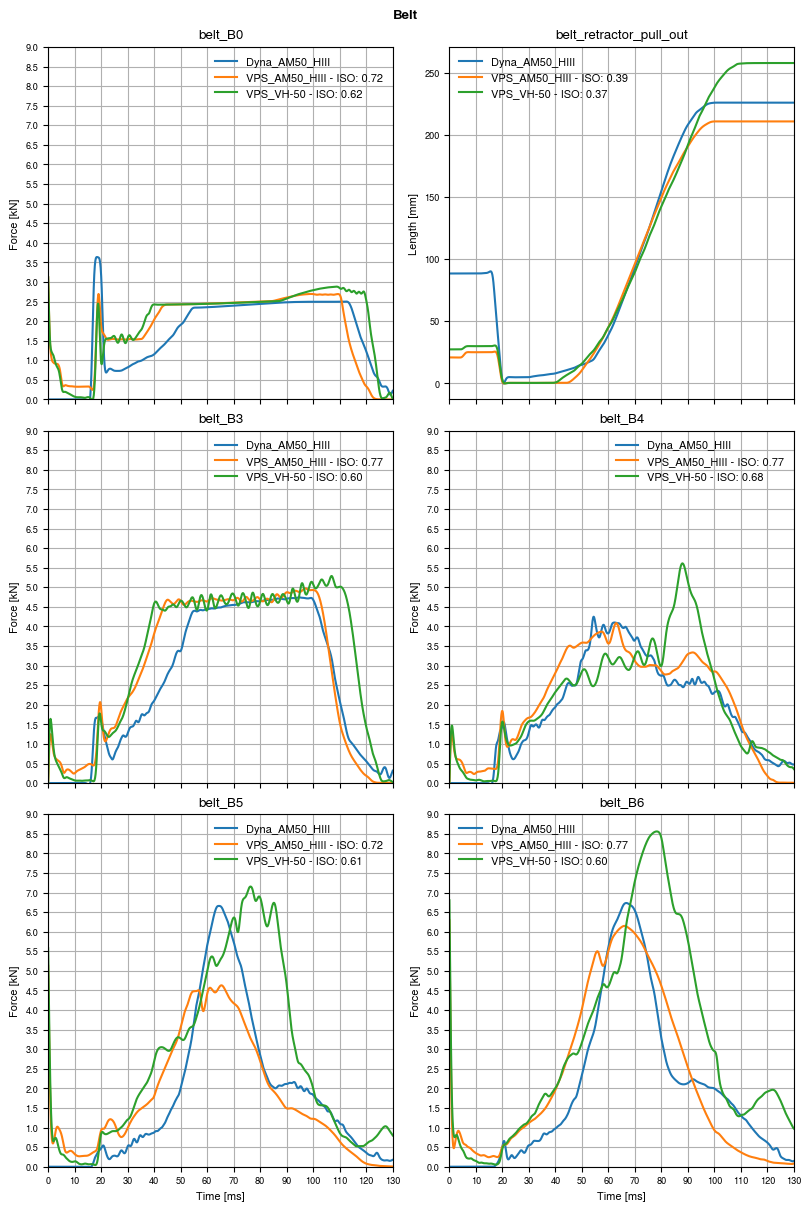

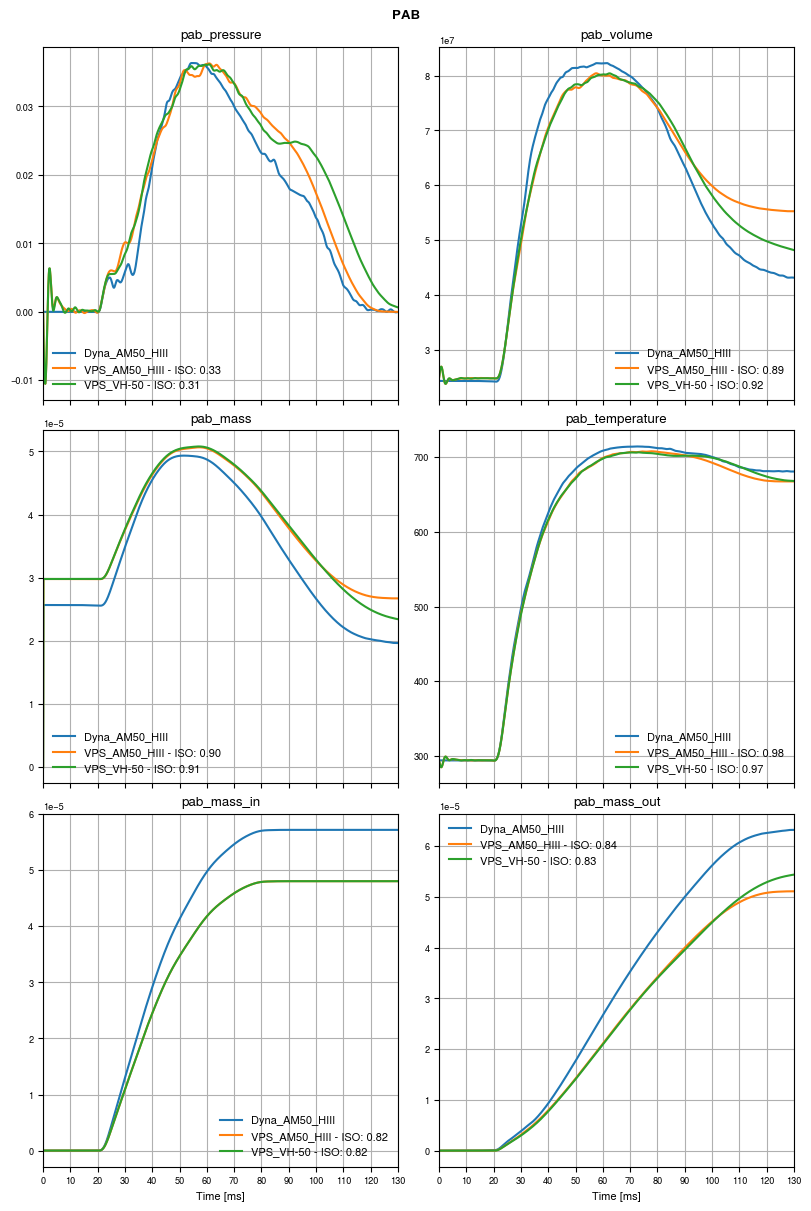

In [8]:
def plot_single():
    mosaics = {
        "Belt": [
            ["belt_B0", "belt_retractor_pull_out"],
            ["belt_B3", "belt_B4"],
            ["belt_B5", "belt_B6"],
        ],
        "PAB": [
            ["pab_pressure", "pab_volume"],
            ["pab_mass", "pab_temperature"],
            ["pab_mass_in", "pab_mass_out"],
        ],
    }

    for mosaic in mosaics:
        fig, ax = plt.subplot_mosaic(
            mosaic=mosaics[mosaic],
            sharex=True,
            layout="constrained",
            figsize=(4 * len(mosaics[mosaic][0]), 4 * len(mosaics[mosaic])),
        )
        fig.suptitle(mosaic)
        for channel in sum(mosaics[mosaic], []):
            if "belt_B" in channel and mosaic == "Belt":
                sc, ylabel = 0.001, "Force [kN]"
            elif mosaic == "Belt":
                sc, ylabel = 1, "Length [mm]"
            else:
                sc, ylabel = 1, ""

            for case in DATA.keys():
                ofs = DATA[case][channel].min() if channel == "belt_retractor_pull_out" else 0
                ofs = 0.1013 if channel == "pab_pressure" and case == "Dyna_AM50_HIII" else ofs
                if case.startswith("VPS"):
                    label = f"{case} - ISO: {ISO_SCORES.loc[channel, case]:.2f}"
                else:
                    label = case
                ax[channel].plot(DATA[case].index, DATA[case][channel] * sc - ofs, label=label)
            ax[channel].set_title(channel)
            ax[channel].legend()
            ax[channel].grid()
            if channel in set(mosaics[mosaic][-1]):
                ax[channel].set_xlabel("Time [ms]")
            ax[channel].set_ylabel(ylabel)
            if "belt_B" in channel and mosaic == "Belt":
                ax[channel].set_ylim(0, 9)
                ax[channel].set_yticks(np.arange(0, 9.1, 0.5))
            ax[channel].set_xlim(0, 130)
            ax[channel].set_xticks(np.arange(0, 131, 10))


plot_single()